In [3]:
import re
import pandas as pd 
import numpy as np 
import random 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 

In [4]:
df = pd.read_csv("\\Users\\Mahesa\\Documents\\INI KULIAH BUKAN MAIN MAIN\\Competition\\GEMASTIK 2022\\Data Mining\\src\data\\newsdatasetshuffle_4000.csv")
raw_data = df.iloc[:,3:].drop('timestamp', axis=1)
raw_data.head()

,title,label
0,"Stok Gula Aman, Pabrik Makanan Siap Ngebut Lagi",industri
1,"Secuplik Nestapa Ethiopia, Negara Miskin yang ...",perang
2,Ssstt!! Ini Rahasia Tajir Jual-Beli Properti,properti
3,Menteri Era SBY Yakin Nadiem Makarim Majukan P...,teknologi
4,"Dewan Kolonel Vs Dewan Kopral, Perang Dukungan...",perang


In [5]:
raw_data = raw_data.astype(str)

In [6]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')
len(stopwords_ind)

758

In [7]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [8]:
raw_data

,title,label
0,"Stok Gula Aman, Pabrik Makanan Siap Ngebut Lagi",industri
1,"Secuplik Nestapa Ethiopia, Negara Miskin yang ...",perang
2,Ssstt!! Ini Rahasia Tajir Jual-Beli Properti,properti
3,Menteri Era SBY Yakin Nadiem Makarim Majukan P...,teknologi
4,"Dewan Kolonel Vs Dewan Kopral, Perang Dukungan...",perang
...,...,...
3995,"Mudahkan Penanaman Modal di IKN, Pemerintah Si...",pemerintahan
3996,Warning! IMF Pangkas Proyeksi Ekonomi Dunia 20...,properti
3997,Mencekam! Pasukan Kurdi Kontak Senjata Lawan I...,perang
3998,10 Fakta Menarik Wajib Militer di Korea Selatan,pemerintahan


In [9]:
def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

%time
raw_data['title'] = raw_data['title'].apply(text_preprocessing)
raw_data['title'] = raw_data['title'].apply(remove_stop_words)
raw_data['title'] = raw_data['title'].apply(stemming)

Wall time: 0 ns


In [10]:
raw_data.head()

,title,label
0,stok gula aman pabrik makan ngebut,industri
1,cuplik nestapa ethiopia negara miskin jebak pe...,perang
2,ssstt rahasia tajir jualbeli properti,properti
3,menteri era sby nadiem makarim maju didik ri,teknologi
4,dewan kolonel vs dewan kopral perang dukung pu...,perang


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
raw_data['label'] = le.fit_transform(raw_data['label'])

In [12]:
raw_data.head()

,title,label
0,stok gula aman pabrik makan ngebut,0
1,cuplik nestapa ethiopia negara miskin jebak pe...,2
2,ssstt rahasia tajir jualbeli properti,3
3,menteri era sby nadiem makarim maju didik ri,4
4,dewan kolonel vs dewan kopral perang dukung pu...,2


In [13]:
le.classes_

array(['industri', 'pemerintahan', 'perang', 'properti', 'teknologi'],
      dtype=object)

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(raw_data, test_size=0.15,random_state = 10)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state = 10)

df_train.shape, df_test.shape, df_val.shape

((3400, 2), (300, 2), (300, 2))

In [15]:
PRE_TRAINED_MODEL = 'indolem/indobert-base-uncased'
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [16]:
vocabulary = bert_tokenizer.get_vocab()

print('Panjang vocabulary:', len(vocabulary))

Panjang vocabulary: 31923


In [17]:
print('Kalimat:', raw_data.title[10])
print('BERT Tokenizer:', bert_tokenizer.tokenize(raw_data.title[10]))

Kalimat: anakanak lansia lviv ukraina latih senjata
BERT Tokenizer: ['anakan', '##ak', 'lansia', 'l', '##vi', '##v', 'ukraina', 'latih', 'senjata']


In [18]:
bert_input = bert_tokenizer.encode_plus(
    raw_data.title[10],             # Sample kalimat                
    add_special_tokens = True,      # Tambahkan token [CLS] pada awal kalimat dan token [SEP] pada akhir kalimat
    padding = 'max_length',         # Tambahkan padding ke max_length menggunakan token [PAD] jika kalimat kurang dari max_length
    truncation = 'longest_first',   # Truncate jika kalimat lebih dari max_length
    max_length = 30,                # Tentukan max_length dari seluruh kalimat
    return_attention_mask = True,   # Mengembalikan nilai attention mask
    return_token_type_ids =True     # Mengembalikan nilai token type id (segment embedding)
    )

# Fungsi `encode_plus` mengembalikan 3 nilai: input_ids, token_type_ids, attention_mask
bert_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [19]:
print('Kalimat\t\t:', raw_data.title[10])                                           # Data asli
print('Tokenizer\t:', bert_tokenizer.convert_ids_to_tokens(bert_input['input_ids']))    # Hasil input formatting + tokenizer
print('Input IDs\t:', bert_input['input_ids'])                                          # Input IDs : indeks token pada vocabulary tokenizer
print('Token Type IDs\t:', bert_input['token_type_ids'])                                # Token type IDs : menunjukkan urutan kalimat pada sequence (segment embedding)
print('Attention Mask\t:', bert_input['attention_mask'])                                # Attention mask : mengembalikan nilai [0,1]. 1 artinya token yang di masking, 0 token yang tidak di masking (diabaikan)

Kalimat		: anakanak lansia lviv ukraina latih senjata
Tokenizer	: ['[CLS]', 'anakan', '##ak', 'lansia', 'l', '##vi', '##v', 'ukraina', 'latih', 'senjata', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs	: [3, 26299, 1484, 27662, 54, 6952, 957, 9687, 5050, 3616, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token Type IDs	: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask	: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


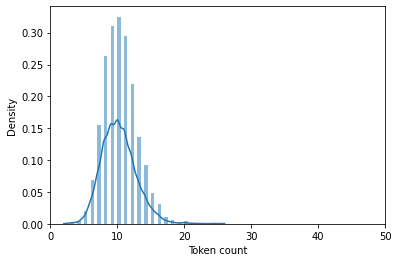

In [20]:
# Menentukan Max Length
token_lens = []

for txt in raw_data.title:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 50]);
plt.xlabel('Token count');

In [21]:
# ENCODE
MAX_LEN = 40
def convert_example_to_feature(sentence):  
  return bert_tokenizer.encode_plus(
      sentence, 
      add_special_tokens = True, 
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN, 
      return_attention_mask = True, 
      return_token_type_ids=True
    )
  
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for sentence, label in data.to_numpy():

    bert_input = convert_example_to_feature(sentence)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [22]:
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 7e-5

In [23]:
train_encoded = encode(df_train).batch(BATCH_SIZE)
test_encoded = encode(df_test).batch(BATCH_SIZE)
val_encoded = encode(df_val).batch(BATCH_SIZE)

In [24]:
from transformers import TFBertForSequenceClassification,BertConfig

# Load model
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL)
config.num_labels = 5
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, config=config,from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Karena tidak menggunakan one-hot vectors, sehingga loss function dapat menggunakan sparse categorical cross entropy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile model
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [26]:
bert_history = bert_model.fit(train_encoded, epochs=5, batch_size=BATCH_SIZE, validation_data=val_encoded)

Epoch 1/5
107/107 [==============================] - 378s 3s/step - loss: 1.1887 - accuracy: 0.5062 - val_loss: 0.6487 - val_accuracy: 0.8067
Epoch 2/5
107/107 [==============================] - 346s 3s/step - loss: 0.6562 - accuracy: 0.7809 - val_loss: 0.6383 - val_accuracy: 0.8167
Epoch 3/5
107/107 [==============================] - 358s 3s/step - loss: 0.5299 - accuracy: 0.8315 - val_loss: 0.5840 - val_accuracy: 0.8433
Epoch 4/5
107/107 [==============================] - 359s 3s/step - loss: 0.4569 - accuracy: 0.8550 - val_loss: 0.6189 - val_accuracy: 0.8267
Epoch 5/5
107/107 [==============================] - 368s 3s/step - loss: 0.3938 - accuracy: 0.8800 - val_loss: 0.6252 - val_accuracy: 0.8133


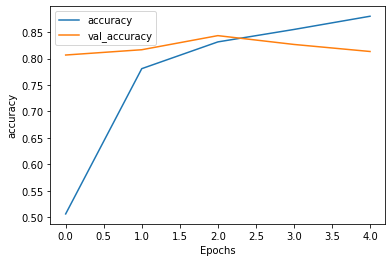

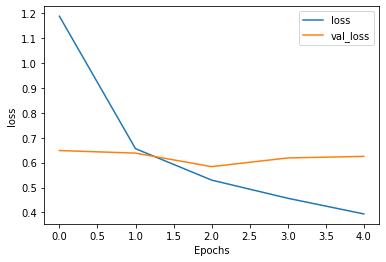

In [27]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [28]:
bert_model.save_weights('indobert-base-uncased_model_rs10.h5')

In [29]:
score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

10/10 [==============================] - 10s 945ms/step - loss: 0.9709 - accuracy: 0.7400
Test Accuracy: 0.7400000095367432


In [30]:
input_text = 'Waduh... Pabrik Batu Bara di Inggris Dihancurkan, Kenapa?'

# Encode input text
input_text_tokenized = bert_tokenizer.encode(input_text,
                                             truncation=True,
                                             padding='max_length',
                                             return_tensors='tf')

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [31]:
bert_predict = bert_model(input_text_tokenized)          
bert_output = tf.nn.softmax(bert_predict[0], axis=-1)         
label = tf.argmax(bert_output, axis=1)
label = label.numpy()
print(label)

[0]


In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
le.classes_

array(['industri', 'pemerintahan', 'perang', 'properti', 'teknologi'],
      dtype=object)

In [33]:
def predict_test(data):
    predict_y = []
    for i in data:
        input_text_tokenized = bert_tokenizer.encode(i,
                                                truncation=True,
                                                padding='max_length',
                                                return_tensors='tf')
        bert_predict = bert_model(input_text_tokenized)
        bert_output = tf.nn.softmax(bert_predict[0], axis=-1)
        label = tf.argmax(bert_output, axis=1)
        label = label.numpy()
        predict_y.append(label)
    return predict_y

predict_y = predict_test(df_test['title'].values)

In [34]:
y = classification_report(df_test['label'].values,predict_y)
print(classification_report(df_test['label'].values,predict_y,target_names=le.classes_))

              precision    recall  f1-score   support

    industri       0.54      0.74      0.62        53
pemerintahan       0.83      0.75      0.79        71
      perang       0.69      0.92      0.79        62
    properti       0.97      0.59      0.73        56
   teknologi       0.85      0.69      0.76        58

    accuracy                           0.74       300
   macro avg       0.78      0.74      0.74       300
weighted avg       0.78      0.74      0.74       300



[Text(0, 0.5, 'industri'),
 Text(0, 1.5, 'pemerintahan'),
 Text(0, 2.5, 'perang'),
 Text(0, 3.5, 'properti'),
 Text(0, 4.5, 'teknologi')]

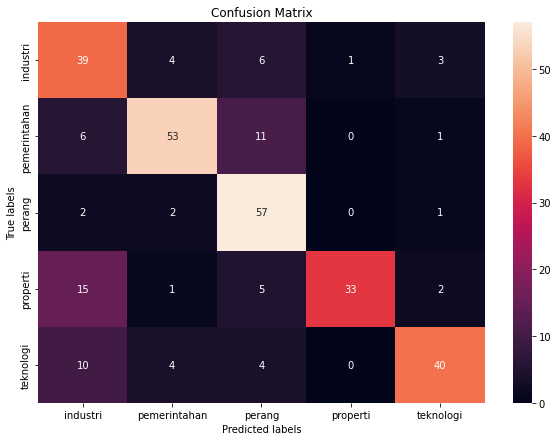

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(confusion_matrix(df_test['label'].values, predict_y),annot=True,ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

In [36]:
lst = ['Pemerintah Menetapkan Batas Tarif Tertinggi Rapid Test Antigen Covid-19','Pemerintah Izinkan Warga di Bawah 45 Tahun Kembali Beraktivitas ','Pengamat Minta Pemerintah Tetap Buka Impor Produk dari Cina','Tuntut Upah Naik 13 Persen, Demo Buruh Nyalakan Smoke Bomb di Patung Kuda','BPS Beberkan Kondisi Ekspor RI ke Cina Selama Pandemi dan Perang Rusia-Ukraina','Perang Ukraina, Tentara Belarus Bergabung dengan Rusia','Jika Ukraina Bergabung NATO, Pejabat Rusia: Perang Dunia III Akan Terjadi','Ini Bahaya Radiasi Nuklir bagi Manusia Jika Perang Nuklir Dunia Terjadi','Alasan Gibran Wajibkan Industri Kecil dan Menengah di Solo Go Digital','Qualcomm, Razer dan Verizon Perkenalkan Perangkat Game 5G dengan Snapdragon G3x','Smarthome Samsung - Google: Apapun Perangkatnya, Aplikasinya Tetap','Energy Watch Beberkan Kendala Listrik Tenaga Surya: Belum Ada Teknologi Baterai Murah','Mahasiswa Universitas Teknologi Sumbawa Bikin Mobil Listrik, Namanya NgebUTS','Mandiri Festival Properti Indonesia 2022 Hadirkan 37 Projek dari 17 Pengembang','Pemerintah Maksimalkan Potensi Industri Kopi Nasional','Industri Haus Listrik Terancam Gulung Tikar, Kadin: Investor Pelan-pelan Pindah ke Luar Negeri','Manfaat Garam dalam Industri dan Medis Modern','CEO Avoskin Cerita Awal Bangun Usaha, Kumpulkan Tabungan Sejak Jadi Agen Properti','Festival Properti Indonesia Digelar, Ada Promo KPR Mandiri Berbunga 2,4 Persen','Deal, Ciputra Group Berkomitmen Bangun Properti 300 Hektar di IKN ']
classes = ['industri', 'pemerintahan', 'perang', 'properti', 'teknologi']

lst_new = []
for i in range(len(lst)):
    txt = text_preprocessing(lst[i])
    txt_1 = remove_stop_words(txt)
    txt_2 = stemming(txt_1)
    # clean = vec_TF_IDF.fit_transform(txt_2)
    # predict = model.predict(clean)
    lst_new.append(txt_2)

In [43]:
predict = []
for i in lst_new:
    input_text_tokenized = bert_tokenizer.encode(i,
                                                truncation=True,
                                                padding='max_length',
                                                return_tensors='tf')
    bert_predict = bert_model(input_text_tokenized)          
    bert_output = tf.nn.softmax(bert_predict[0], axis=-1)         
    label = tf.argmax(bert_output, axis=1)
    label = label.numpy()[0]
    
    predict.append(label)

In [44]:
predict

[1, 1, 1, 1, 2, 2, 2, 2, 0, 4, 4, 4, 4, 3, 0, 0, 0, 3, 3, 3]